# PyTorch: Autoencoder convolucional Fashion-MNIST

## Refs.

* https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

* https://github.com/zalandoresearch/fashion-mnist

* https://github.com/pranay414/Fashion-MNIST-Pytorch/blob/master/fashion_mnist.ipynb

## **Ejercicio 1)** Importando librerías

**0)** De ser necesario, **instale PyTorch** escribiendo

    !pip3 install torch torchvision torchaudio torchviz

**1)** Importe las librerías estandard de Python: `os`, `datetime`, `collections` y `pickle`.

**2)** Importe las siguientes librerías third party de Python: `matplotlib.pyplot`, `numpy`, `scipy`, `sklearn`, `pandas`, `dill` y `json`.

**3)** Importe las librerias necesarias de **PyTorch**: `torch` y `torchvision`.

**4)** Importe la librería: `google.colab`.

In [2]:
# 1.0)
!pip3 install torch torchvision torchaudio torchviz


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [3]:
# 1.1)
import os
import pickle
import datetime
from collections import defaultdict

In [4]:
# 1.2)
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import scipy as sp
import scipy.linalg as linalg
#import dill
import json

In [49]:
# 1.3)
import torch
import torch.optim as optim
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import datasets
from torchvision import transforms
from torchvision.io import read_image
from torchvision.transforms import ToTensor, Lambda, Compose
import torchvision 
#from torchviz import make_dot
from tqdm import tqdm

In [6]:
# 1.4)
""" 
import google.colab
from google.colab import files
"""

' \nimport google.colab\nfrom google.colab import files\n'

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## **Ejercicio 2)**

Bajando y Jugando con el dataset **Fashion-MNIST**.

**1)** Baje y transforme los conjuntos de entrenamiento y testeo de FashionMNIST.

**2)** Grafique un mosaico de 3x3 imagenes de FashionMNIST, cada una titulada con su respectiva clasificación

In [8]:
# 2.1)
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
train_set_orig = datasets.FashionMNIST('MNIST_data/', download = True, train = True,  transform = transform)
valid_set_orig = datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)

In [91]:
#train_set_orig[40]

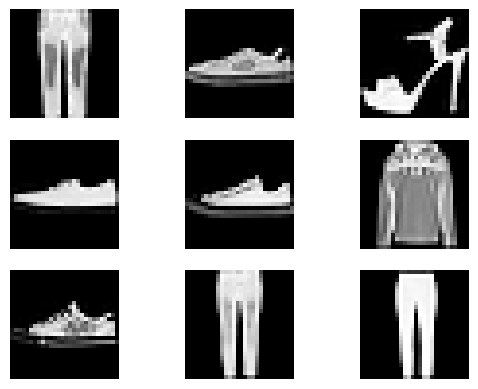

In [10]:
# 2.2)
figure = plt.figure()
cols,rows = 3,3
for i in range(1,cols*rows+1):
    j = torch.randint(len(train_set_orig),size=(1,)).item() # Los números aleatorios tambien se pueden generar desde pytorch. Util para trabajar en la GPU.
    image,label = train_set_orig[j]
    figure.add_subplot(rows,cols,i)
    #plt.title(labels_names[label])
    plt.axis("off")
    plt.imshow(image.squeeze(),cmap="Greys_r")
plt.show()

## Ejercicio 3) Creando un `DataSet` personalizado.

**1)** Con el fin de implementar un autoencoder, cree una clase derivada de la clase `DataSet` (llámela, por ejemplo `CustomDataset`) que, en vez de retornal el label asociado a cada imagen de `FashionMNIST`, retorne la imagen misma.

**2)** Utilice dicha clase para transformar los conjuntos de entrenamiento y testeo de `FashionMNIST` pensados para clasificación, a correspondientes conjuntos pensados para entrenar un autoencoder.
Para ello, defina una clase `CustomDataset` que deriva de la clase `Dataset`, cuyo método `__getitem__(self,i)` retorne el pair `input,output` donde tanto `input` cómo `output` son iguales a la $i$-ésima imagen del dataset.

In [11]:
# 3.1)
class CustomDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        return image, image

In [12]:
train_set_autoencoder = CustomDataset(train_set_orig)
valid_set_autoencoder = CustomDataset(valid_set_orig)

## Ejercicio 4) Red Neuronal Autoencoder Convolucional

**1)** Defina y cree una red neuronal *autoenconder convolucional* constituida por las siguientes capas:

1. Una capa convolucional 2D constituida por:

* Una capa `Conv2d` (ver https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) que deberá mapear $1$ canal de entradas de dimensiones $(28,28)$ a $16$ canales de de salida de dimensiones $(26,26)$. Para ello utilice un kernel de dimensiones $(3,3)$ y el resto de los parámetros en sus valores por defecto.
* Una capa `ReLU`.
* Una capa `Dropout`.
* Una capa `MaxPool` (ver https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) con un kernel de dimensiones $(2,2)$, de manera que mapeará entradas de dimensiones $(26,26)$ a salidas de dimensiones $(13,13)$.

2. Una capa lineal constituida por:

* Una capa `Flatten` que mapea una entrada de $16$ canales de dimensiones $(13,13)$ a un vector de dimensión $16\times 13\times 13$.
* Una capa `Linear` que mapea un vector de dimensión $16\times 13\times 13$ a un vector de dimensión $n$.
* Una capa `ReLU`.
* Una capa `Dropout`.

3. Una capa capa convolucional 2D transpuesta, constituida por:

* una capa `ConvTranspose2d` (ver https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) que mapea $16$ canales de dimensiones $(13,13)$ a $1$ canal de dimensiones $(28,28)$. Para ello, utilice un kernel de dimensiones $(6,6)$ y un stride de dimensiones $(2,2)$, dejando el resto de los parámetros en sus valores por defecto, i.e. padding de $(1,1)$ y out_padding de $(0,0)$.

* Una capa `Sigmoid`.

**3)** Grafique, a modo de comparación, unas pocas imagenes a predecir vs las correspondientes imagenes predichas utilizando el modelo sin entrenar y dropout $p=0.2$.

In [36]:
# 4.1)
class Autoencoder(nn.Module):
    def __init__(self, dropout):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            #nn.Flatten(),
            nn.Conv2d(1, 16, kernel_size=3, padding=0), # (1, 28, 28) -> (16, 26, 26)
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.MaxPool2d(2,2) # (16, 26, 26) -> (16, 13, 13)
        )
        self.linear = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16*13*13, 16*13*13), # FULLY CONNECTED
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (16,13,13)),
            nn.ConvTranspose2d(16,1,kernel_size=6, stride = 2, padding=1), # (16, 13, 13) -> (1, 28, 28)
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.linear(x)
        x = self.decoder(x)
        return x

In [37]:
p = 0.2
model = Autoencoder(p)
model.to(device)

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2704, out_features=2704, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (0): Unflatten(dim=1, unflattened_size=(16, 13, 13))
    (1): ConvTranspose2d(16, 1, kernel_size=(6, 6), stride=(2, 2), padding=(1, 1))
    (2): Sigmoid()
  )
)

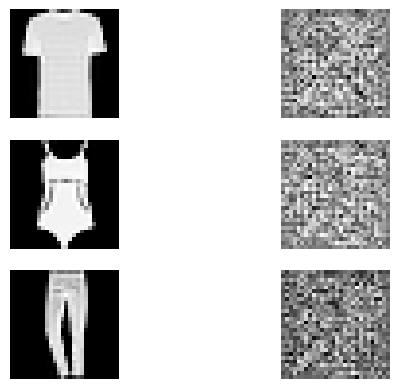

In [38]:
figure = plt.figure()
rows,cols = 3,2

# print 3 images and their reconstructions
for i in range(1,rows+1):
    j = torch.randint(len(train_set_autoencoder),size=(1,)).item()
    image,_ = train_set_autoencoder[j]
    image = image.unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image)
    figure.add_subplot(rows,cols,2*i-1)
    plt.axis("off")
    plt.imshow(image.squeeze().cpu(),cmap="Greys_r")
    figure.add_subplot(rows,cols,2*i)
    plt.axis("off")
    plt.imshow(output.squeeze().cpu(),cmap="Greys_r")

## Ejercicio 5) Entrenando el modelo

**1)** Implemente, en una función, un loop de entrenamiento que recorra los batchs (lotes).

**2)** Implemente, en una función, un loop de prueba o validación que recorra los batchs.

**3)** Inicialize dos `DataLoader`s llamados `train_loader` y `valid_loader` que estén definidos sobre  el `train_set` (conjunto de entranmiento) y el `valid_set` (conjunto de prueba) de Fashion-MNIST, respectivamente, y que usen batchs de 100 ejemplos.

**4)** Cree una función de pérdida usando el **Error Cuadrático Medio**.

**5)** Cree un optimizador con un learning rate igual a $10^{-3}$.
Pruebe con **ADAM**.

**6)** Cree una instancia del modelo con dropout $p=0.2$.

**7)** Especifique en que dispositivo (`device`) va a trabajar: en una **CPU** o en una **GPU**.

**8)** Implemente un loop que itere sobre épocas de entrenamiento y validación, y que guarde en listas correspondientes los siguientes valores del **ECM**:
*  promedios (incorrectos) sobre el conjunto de entrenamiento, calculado **durante** el proceso de entrenamiento sobre la época.
*  promedios (correctos) sobre el conjunto de entrenamiento, calculados **posteriormente** al proceso de entrenamiento sobre la época.
*  promedios (correctos) sobre el conjunto de validación, calculados **posteriormente** al proceso de entrenamiento sobre la época.

**IMPORTANTE:** No olvide copiar los batchs al dispositivo de trabajo.

**9)** Entrene y valide el modelo.

**10)** Use las listas del inciso **8)** para graficar en función de las **épocas de entrenamiento** el **ECM** de **entrenamiento** y **validación**, respectivamente.
Discuta y comente, cual es el número óptimo de épocas de entrenamiento?

**11)** Grafique, comparativamente, algunas de las imagenes a predecir vs las imagenes predichas por el modelo entrenado.

**12)** Repita para otras elecciones de los hiperparámetros tales como, el optimizador (podría ser el **SGD**), el **learning-rate**, el tamaño de los **batchs**, el **dropout**, **capas convolucionales** y **convolucionales traspuestas** de otros tamaños.
En particular, pruebe eliminando, adecuadamente, la **capa lineal**.
Que valores de estos hiperparámetros considera los más convenientes? Porqué?

In [ ]:
# 5.1)
def train_one_epoch(model, train_loader, optimizer, criterion):
  """`
  Trains the model for all the batches in train_loader

  Returns:
  - avg entropy loss
  - avg accuracy
  """
  model.train() # Se pone el modelo en modo de entrenamiento
  sum_batch_avg_loss = 0 # Inicializamos la suma de las pérdidas promedio de los batches

  num_processed_examples = 0 # Inicializamos la cantidad de ejemplos procesados
  for batch_number, (images, labels) in enumerate(train_loader):
      device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

      images = images.to(device) # Se envía la imagen al dispositivo
      labels = labels.to(device) # Se envía la etiqueta al dispositivo

      batch_size = len(images) # Se obtiene el tamaño del lote
      # Se obtiene la predicción del modelo y se calcula la pérdida 
      pred = model(images)
      loss = criterion(pred, labels)
      
      # Backpropagation usando el optimizador 
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      # Calculamos la perdida promedio del batch y lo agregamos a la suma total
      batch_avg_loss = loss.item() 
      sum_batch_avg_loss += batch_avg_loss
      
      # Calculamos la cantidad total de predicciones procesadas
      num_processed_examples += batch_size
      
  # Calculamos la perdida promedio de todos los batches
  avg_loss = sum_batch_avg_loss / len(train_loader)
  # Calculamos la precisión del modelo
  return avg_loss

In [40]:
def validation_loop(model, valid_loader, criterion):
    model.eval() # Se pone el modelo en modo de evaluación

    sum_batch_avg_loss = 0 # Inicializamos la suma de las pérdidas promedio de los batches
    num_processed_examples = 0 # Inicializamos la cantidad de ejemplos procesados

    for batch_number, (images, labels) in enumerate(valid_loader):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        images = images.to(device) # Se envía la imagen al dispositivo
        labels = labels.to(device) # Se envía la etiqueta al dispositivo
      
        batch_size = len(images)

        # Se obtiene la predicción del modelo y se calcula la pérdida
        pred = model(images)
        loss = criterion(pred, labels)

        # Calculamos la perdida promedio del batch y lo agregamos a la suma total
        batch_avg_loss = loss.item()
        sum_batch_avg_loss += batch_avg_loss
        
        # Calculamos la cantidad total de predicciones procesadas
        num_processed_examples += batch_size

    # Calculamos la perdida promedio de todos los batches
    avg_loss = sum_batch_avg_loss / len(valid_loader)
    # Calculamos la precisión del modelo

    return avg_loss

In [41]:
def train_model(model, train_loader, valid_loader, optimizer, criterion, epochs):
  train_entropy_loss_incorrect = []
  train_entropy_loss = []
  
  valid_entropy_loss = []
  for epoch in tqdm(range(epochs)):

    # train one epoch
    train_entropy_inc = train_one_epoch(model, train_loader, optimizer, criterion)
    train_entropy_loss_incorrect.append(train_entropy_inc)

    # check avg loss and accuracy for incorrect predictions
    train_entropy = validation_loop(model, train_loader, criterion)
    train_entropy_loss.append(train_entropy)

    # validate the epoch
    valid_entropy = validation_loop(model, valid_loader, criterion)
    valid_entropy_loss.append(valid_entropy)

  return train_entropy_loss_incorrect, train_entropy_loss, valid_entropy_loss

In [92]:
p = 0.2
model = Autoencoder(p)
model.to(device)

train_loader = DataLoader(train_set_autoencoder, batch_size=100, shuffle=True, num_workers=os.cpu_count()-1)
valid_loader = DataLoader(valid_set_autoencoder, batch_size=100, shuffle=False, num_workers=os.cpu_count()-1)

lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)

criterion = nn.MSELoss()

epochs = 10

#train_entropy_loss_incorrect, train_entropy_loss, valid_entropy_loss = train_model(model, train_loader, valid_loader, optimizer, criterion, epochs)

In [ ]:
!python3 guia13.py

 80%|██████████████████████████████████▍        | 40/50 [59:26<15:15, 91.55s/it]

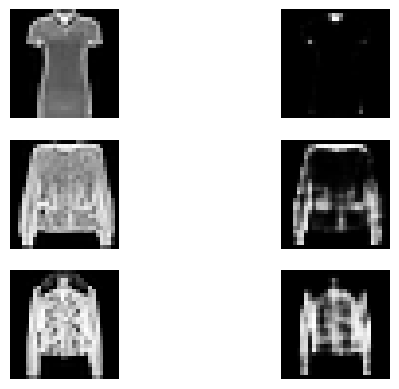

In [74]:
figure = plt.figure()
rows,cols = 3,2

# print 3 images and their reconstructions
for i in range(1,rows+1):
    j = torch.randint(len(train_set_autoencoder),size=(1,)).item()
    image,_ = train_set_autoencoder[j]
    image = image.unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image)
    figure.add_subplot(rows,cols,2*i-1)
    plt.axis("off")
    plt.imshow(image.squeeze().cpu(),cmap="Greys_r")
    figure.add_subplot(rows,cols,2*i)
    plt.axis("off")
    plt.imshow(output.squeeze().cpu(),cmap="Greys_r")